In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import os


In [9]:
def test_images(model_loaded, batch_size):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory('test images'
                                                                  ,image_size=(150,150)
                                                                  ,shuffle=False
                                                                  ,label_mode='binary'
                                                                  ,batch_size=batch_size)
    class_names = test_ds.class_names
    
    plt.figure(figsize=(15, 17))

    for images, labels in test_ds:

        for i in range(len(images)):
            img = images[i]
            img_array = image.img_to_array(img)
            img_batch = np.expand_dims(img_array, axis=0)

            prediction = model_loaded.predict(img_batch)
            
            if prediction[0][0] < 0.50:
                result = 0
                chance = round((1 - prediction[0][0]) * 100, 1)
            else: 
                result = 1
                chance = round(prediction[0][0] * 100, 1) 

            ax = plt.subplot(7, 8, i + 1)
            plt.imshow(img.numpy().astype('uint8'))
            plt.title(str(class_names[int(labels[i])][-1]) + '_' + str(result) + '_' + str(chance))
            plt.axis('off')
    print('actual_predict_%')        
    plt.show()
    model_loaded.evaluate(test_ds, verbose=1)
    

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('images'
                                                               ,image_size=(150,150)
                                                               ,batch_size=32
                                                               ,seed=29
                                                               ,label_mode='binary'
                                                               ,validation_split=0.20
                                                               ,subset='training')

validation_ds = tf.keras.preprocessing.image_dataset_from_directory('images'
                                                                    ,image_size=(150,150)
                                                                    ,batch_size=32
                                                                    ,seed=29
                                                                    ,label_mode='binary'
                                                                    ,validation_split=0.20
                                                                    ,subset='validation')
class_names = train_ds.class_names
class_names

train_ds = train_ds.prefetch(buffer_size=10)
validation_ds = validation_ds.prefetch(buffer_size=10)

Found 1227 files belonging to 2 classes.
Using 982 files for training.
Found 1227 files belonging to 2 classes.
Using 245 files for validation.


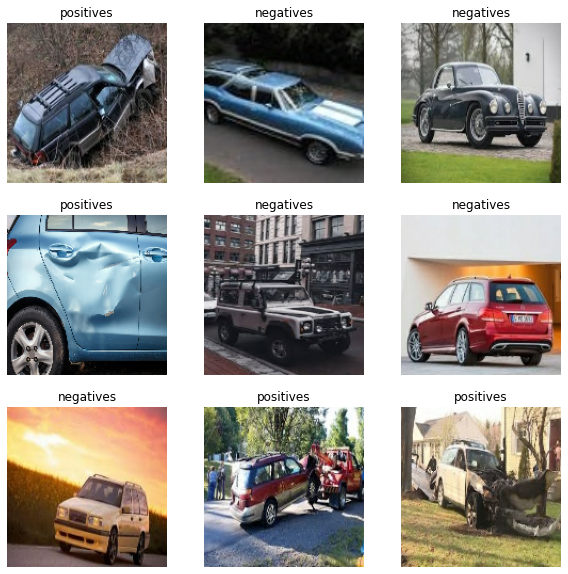

In [3]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')

In [4]:
data_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal')
                             ,layers.experimental.preprocessing.RandomRotation(0.1)
                            ])

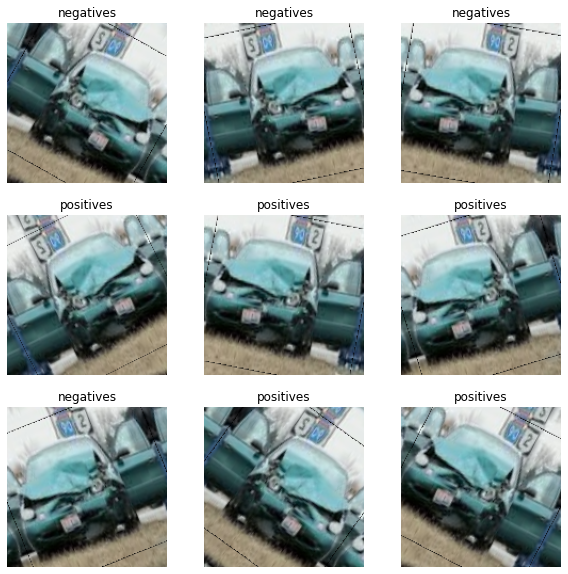

In [5]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    first_image = images[4]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        aug_img = data_aug(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(aug_img[0].numpy().astype('int32'))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
        

In [6]:
# Initializing Xception Base Model for Transfer Learning
base_model = keras.applications.Xception(weights='imagenet'
                                         ,input_shape=(150, 150, 3)
                                         ,include_top=False)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

#Augment
x = data_aug(inputs)

#Normalize
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])



In [7]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling3D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [8]:
model.compile(optimizer=keras.optimizers.Adam()
             ,loss=keras.losses.BinaryCrossentropy(from_logits=True)
             ,metrics=[keras.metrics.BinaryAccuracy()])

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
31/31 [==============================] - 3s 103ms/step - loss: 0.6650 - binary_accuracy: 0.6334 - val_loss: 0.6350 - val_binary_accuracy: 0.6898
Epoch 2/20
31/31 [==============================] - 2s 57ms/step - loss: 0.6295 - binary_accuracy: 0.7240 - val_loss: 0.6263 - val_binary_accuracy: 0.7143
Epoch 3/20
31/31 [==============================] - 2s 57ms/step - loss: 0.6276 - binary_accuracy: 0.7240 - val_loss: 0.6176 - val_binary_accuracy: 0.7306
Epoch 4/20
31/31 [==============================] - 2s 58ms/step - loss: 0.6216 - binary_accuracy: 0.7587 - val_loss: 0.6212 - val_binary_accuracy: 0.7184
Epoch 5/20
31/31 [==============================] - 2s 58ms/step - loss: 0.6171 - binary_accuracy: 0.7729 - val_loss: 0.6097 - val_binary_accuracy: 0.7592
Epoch 6/20
31/31 [==============================] - 2s 58ms/step - loss: 0.6107 - binary_accuracy: 0.7862 - val_loss: 0.6034 - val_binary_accuracy: 0.7755
Epoch 7/20
31/31 [==============================] - 2s 58ms/step - lo

In [9]:
base_model.trainable = True
model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5)
             ,loss=keras.losses.BinaryCrossentropy(from_logits=True)
             ,metrics=[keras.metrics.BinaryAccuracy()])

epochs=10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

Found 31 files belonging to 2 classes.
actual_predict_%


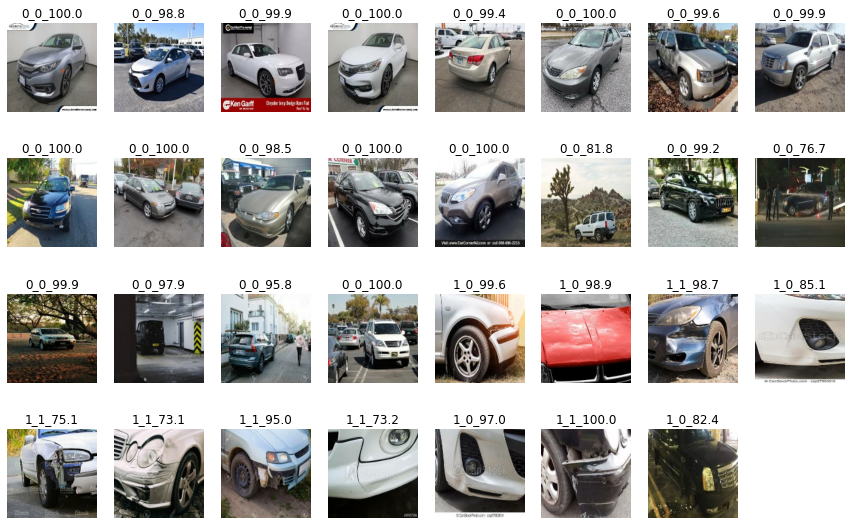

1/1 [==============================] - 0s 890us/step - loss: 0.6308 - binary_accuracy: 0.8387


In [12]:
test_images(model, batch_size=100)

# Training Final Model

In [2]:
# Dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory('images'
                                                               ,image_size=(150,150)
                                                               ,batch_size=32
                                                               ,seed=29
                                                               ,label_mode='binary'
                                                               )

full_ds = full_ds.prefetch(buffer_size=10)

Found 1227 files belonging to 2 classes.


In [3]:
# Load Base Model
base_model = keras.applications.Xception(weights='imagenet'
                                         ,input_shape=(150, 150, 3)
                                         ,include_top=False)
base_model.trainable = False

# Data Aug
data_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal')
                             ,layers.experimental.preprocessing.RandomRotation(0.1)
                            ])

inputs = keras.Input(shape=(150, 150, 3))
x = data_aug(inputs)

# Normalize
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])

# Pipe
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer=keras.optimizers.Adam()
             ,loss=keras.losses.BinaryCrossentropy(from_logits=True)
             ,metrics=[keras.metrics.BinaryAccuracy()])
# Train
epochs = 30
model.fit(full_ds, epochs=epochs)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [4]:
# Fine Tune
base_model.trainable = True
model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5)
             ,loss=keras.losses.BinaryCrossentropy(from_logits=True)
             ,metrics=[keras.metrics.BinaryAccuracy()])

epochs=30
model.fit(full_ds, epochs=epochs)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [5]:
# Saving Model
model.save('model_h5.h5')

In [6]:
# Loading Model

model_loaded = keras.models.load_model('model_h5.h5')

In [7]:
model_loaded.compile(optimizer=keras.optimizers.Adam(1e-5)
                     ,loss=keras.losses.BinaryCrossentropy(from_logits=True)
                     ,metrics=[keras.metrics.BinaryAccuracy()])

#score = model_loaded.evaluate(full_ds)

In [8]:
#model_loaded.metrics_names[1], score[1] * 100

In [13]:
img = image.load_img('test images/1.jpg', target_size=(150,150))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

prediction = model_loaded.predict(img_batch)

plt.imshow(img)
plt.axis('off')
if prediction[0][0] < 0.50:
    print('Not Wreck')
    print( round((1 - prediction[0][0]) * 100, 2) )
else: 
    print('Wreck')
    print(round(prediction[0][0] * 100, 2) )

# Test 4: Ran on laptop

Found 31 files belonging to 2 classes.
actual_predict_%


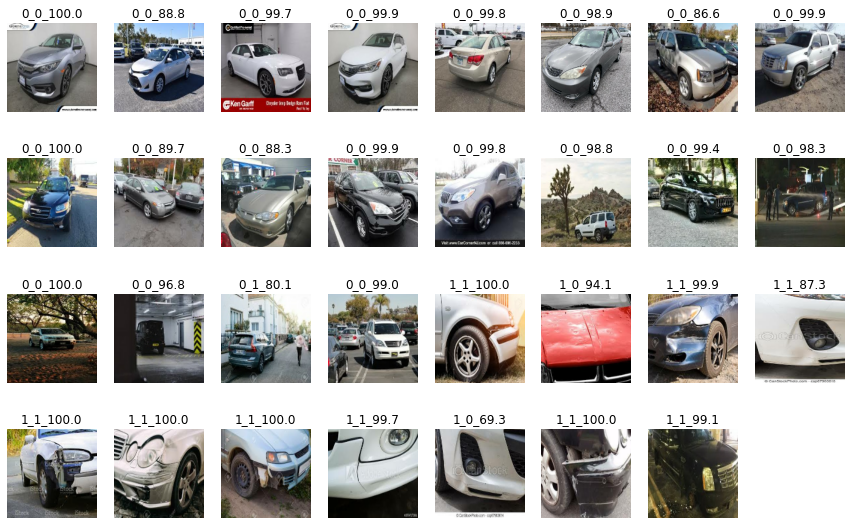

1/1 [==============================] - 0s 876us/step - loss: 0.6034 - binary_accuracy: 0.9032


In [10]:
test_images(model_loaded, 100)

# Test 3: Added more class 1 pics to training set
training loss: 0.5867 - binary_accuracy: 0.8427  
fine tune loss: 0.5278 - binary_accuracy: 0.9690  
Fine tune also had a lowest score of loss: 0.5245 - binary_accuracy: 0.9747  
Perhaps this means a lower learning rate is needed

Found 31 files belonging to 2 classes.
actual_predict_%


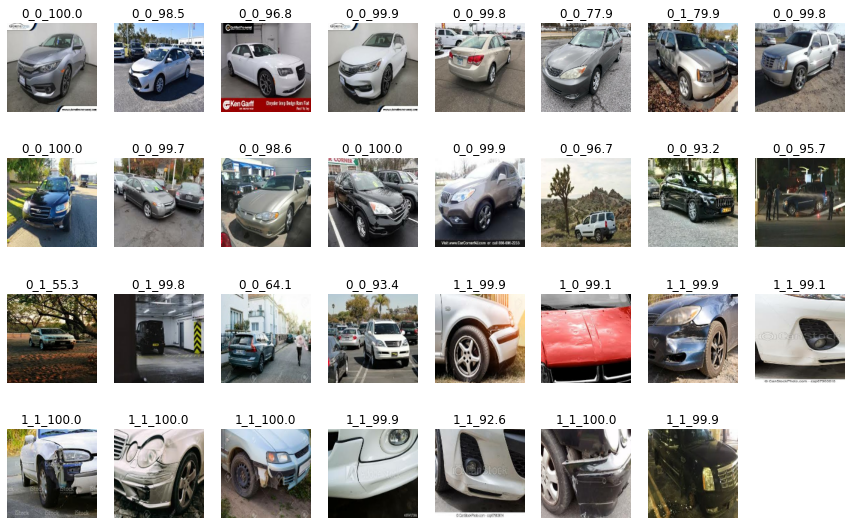

1/1 [==============================] - 0s 966us/step - loss: 0.6314 - binary_accuracy: 0.8710


In [9]:
test_images(model_loaded, 100)

# Test 2: Added the 100% pics to the training set, they were mainly all class 0s

train loss: 0.5983 - binary_accuracy: 0.8624  
fine tune loss: 0.5454 - binary_accuracy: 0.9737  


Found 31 files belonging to 2 classes.
actual_predict_%


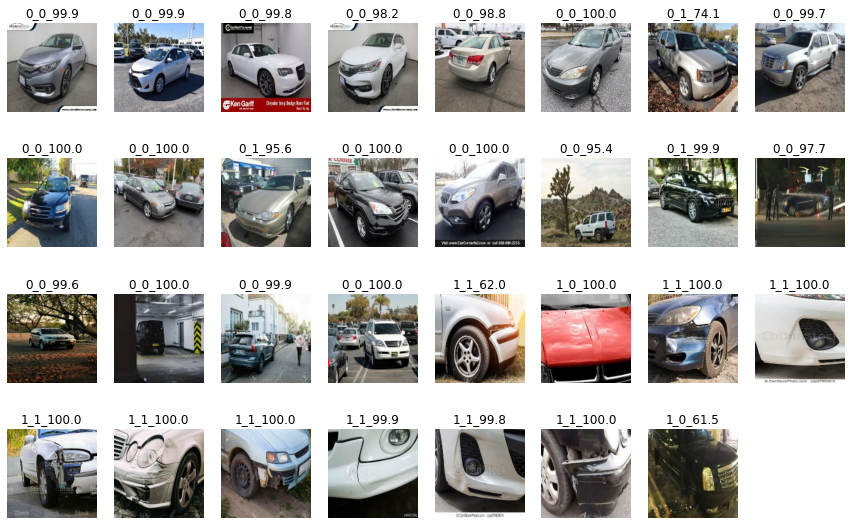

1/1 [==============================] - 0s 2ms/step - loss: 0.6360 - binary_accuracy: 0.8387


In [31]:
test_images(model_loaded, 100)

# Test 1: Added more SUV related pics, would like to see the SUV pics being more accurate
Also increased epoch from 20 -> 30 on train  
and increased epoch from 10 -> 30 for fine tune  

OBS:  
Saw that train loss: 0.5976 - binary_accuracy: 0.8576  
Saw that fine tune loss: 0.5432 - binary_accuracy: 0.9723  

Found 31 files belonging to 2 classes.
actual_predict_%


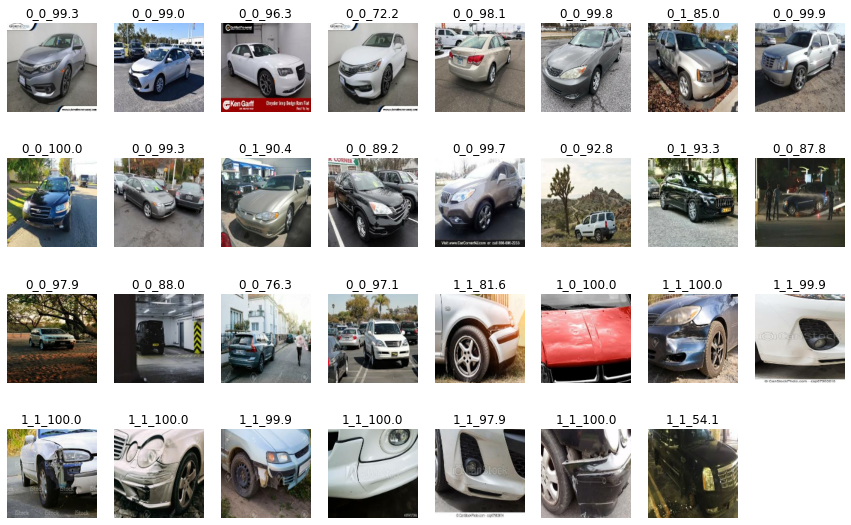

1/1 [==============================] - 0s 2ms/step - loss: 0.6480 - binary_accuracy: 0.8710


In [23]:
test_images(model_loaded, 100)

# 20201123 Standard for testing of adding more SUVs
# Looking to help r4 c3/4 

Found 38 files belonging to 2 classes.


C:\Users\Thompson\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


actual_predict_%


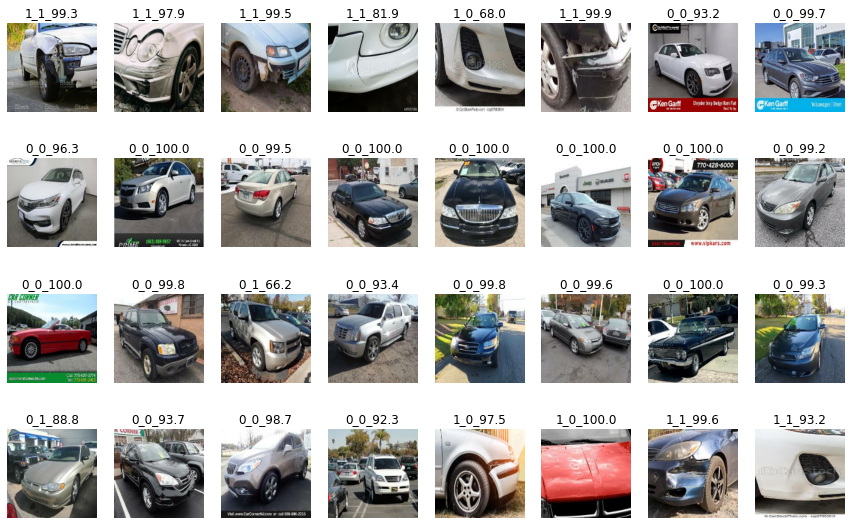

2/2 [==============================] - 0s 10ms/step - loss: 0.6548 - binary_accuracy: 0.8684


In [20]:
test_images(model_loaded)